# Data Analysis - Phân tích dữ liệu

**Người phụ trách:** Người 3 - Data Analyst

## Mục tiêu:
- Phân tích thống kê mô tả
- Tìm patterns và trends
- Phát hiện insights quan trọng
- Đưa ra nhận định và đề xuất


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

# Hàm display() cho Jupyter notebook
try:
    from IPython.display import display
except ImportError:
    # Fallback nếu không có IPython
    def display(obj):
        print(obj)

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

# Đọc dữ liệu đã được làm sạch
try:
    df = pd.read_csv('../data/foodpanda_orders_cleaned.csv')
    print(f"✅ Đã đọc dữ liệu đã làm sạch thành công!")
except FileNotFoundError:
    print("❌ Lỗi: Không tìm thấy file '../data/foodpanda_orders_cleaned.csv'")
    print("⚠️ Thử đọc file gốc...")
    try:
        df = pd.read_csv('../data/foodpanda_orders.csv')
        print("✅ Đã đọc file gốc (chưa làm sạch)")
    except FileNotFoundError:
        print("❌ Không tìm thấy cả hai file!")
        raise

# Chuyển đổi date columns
date_cols = ['signup_date', 'order_date', 'last_order_date', 'rating_date']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], format='%m/%d/%Y', errors='coerce')
    else:
        print(f"⚠️ Cảnh báo: Cột '{col}' không tồn tại trong dữ liệu")

# Tạo cột total_amount - sử dụng total_value nếu có (từ dữ liệu cleaned), nếu không thì tính từ quantity * price
if 'total_value' in df.columns:
    df['total_amount'] = df['total_value']
    print(f"✅ Sử dụng cột 'total_value' từ dữ liệu đã làm sạch")
elif 'quantity' in df.columns and 'price' in df.columns:
    df['total_amount'] = df['quantity'] * df['price']
    print(f"✅ Đã tạo cột 'total_amount' = quantity * price")
else:
    print("❌ Lỗi: Thiếu cột 'total_value' hoặc ('quantity' và 'price')")

# Kiểm tra dữ liệu
print(f"\n📊 Kích thước dữ liệu: {df.shape}")
print(f"📋 Số cột: {len(df.columns)}")
print(f"📋 Các cột: {df.columns.tolist()}")
print(f"\n🔍 Kiểm tra giá trị thiếu:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("✅ Không có giá trị thiếu")

print(f"\n📈 Xem 5 dòng đầu tiên:")
df.head()

✅ Đã đọc dữ liệu đã làm sạch thành công!
✅ Sử dụng cột 'total_value' từ dữ liệu đã làm sạch

📊 Kích thước dữ liệu: (4533, 23)
📋 Số cột: 23
📋 Các cột: ['customer_id', 'gender', 'age', 'city', 'signup_date', 'order_id', 'order_date', 'restaurant_name', 'dish_name', 'category', 'quantity', 'price', 'payment_method', 'order_frequency', 'last_order_date', 'loyalty_points', 'churned', 'rating', 'rating_date', 'delivery_status', 'total_value', 'customer_tenure_days', 'total_amount']

🔍 Kiểm tra giá trị thiếu:
signup_date        4533
order_date         4533
last_order_date    4533
rating_date        4533
dtype: int64

📈 Xem 5 dòng đầu tiên:


,customer_id,gender,age,city,signup_date,order_id,order_date,restaurant_name,dish_name,category,...,order_frequency,last_order_date,loyalty_points,churned,rating,rating_date,delivery_status,total_value,customer_tenure_days,total_amount
0,c5663,male,adult,peshawar,NaT,o9663,NaT,mcdonald's,burger,italian,...,38,NaT,238,active,3,NaT,cancelled,7391.35,552,7391.35
1,c2831,male,adult,multan,NaT,o6831,NaT,kfc,burger,italian,...,24,NaT,81,active,2,NaT,delayed,2868.12,141,2868.12
2,c1694,female,senior,peshawar,NaT,o5694,NaT,subway,pizza,dessert,...,27,NaT,45,inactive,2,NaT,delayed,925.20,688,925.20
3,c4339,other,senior,lahore,NaT,o8339,NaT,kfc,sandwich,dessert,...,35,NaT,418,inactive,3,NaT,cancelled,1156.69,358,1156.69
4,c6543,other,adult,karachi,NaT,o10543,NaT,burger king,pizza,fast food,...,45,NaT,418,inactive,4,NaT,delivered,6068.10,378,6068.10


## Thống kê mô tả

In [2]:
# Thống kê mô tả cho các biến số
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) > 0:
    desc = df[numeric_cols].describe().T
    
    # Thêm các thống kê bổ sung
    desc['median'] = df[numeric_cols].median()
    desc['skewness'] = df[numeric_cols].skew()
    desc['kurtosis'] = df[numeric_cols].kurtosis()
    
    # Mode - xử lý trường hợp có nhiều mode
    mode_values = df[numeric_cols].mode()
    if len(mode_values) > 0:
        # Lấy mode đầu tiên cho mỗi cột
        mode_dict = {}
        for col in numeric_cols:
            col_mode = df[col].mode()
            if len(col_mode) > 0:
                mode_dict[col] = col_mode.iloc[0]
            else:
                mode_dict[col] = np.nan
        desc['mode'] = pd.Series(mode_dict)
    
    print("📊 Thống kê mô tả cho các biến số:")
    display(desc)
else:
    print("⚠️ Không tìm thấy biến số nào trong dữ liệu")

📊 Thống kê mô tả cho các biến số:


,count,mean,std,min,25%,50%,75%,max,median,skewness,kurtosis,mode
quantity,4533.0,3.009486,1.408945,1.00,2.00,3.00,4.00,5.00,3.00,-0.008289,-1.282511,3.00
price,4533.0,799.076717,403.991622,100.30,443.64,804.13,1146.47,1499.95,804.13,0.012308,-1.208391,235.82
order_frequency,4533.0,25.286124,14.294608,1.00,13.00,25.00,37.00,50.00,25.00,0.039659,-1.165741,37.00
loyalty_points,4533.0,249.378557,145.064910,0.00,124.00,247.00,377.00,500.00,247.00,0.016159,-1.207399,8.00
rating,4533.0,2.992720,1.403309,1.00,2.00,3.00,4.00,5.00,3.00,-0.005279,-1.275453,3.00
total_value,4533.0,2403.432791,1755.630915,101.73,996.12,1920.42,3534.76,7496.85,1920.42,0.891248,-0.020564,469.12
customer_tenure_days,4533.0,285.227223,174.018950,0.00,140.00,276.00,417.00,720.00,276.00,0.255380,-0.866224,24.00
total_amount,4533.0,2403.432791,1755.630915,101.73,996.12,1920.42,3534.76,7496.85,1920.42,0.891248,-0.020564,469.12


## Kiểm tra phân phối dữ liệu từng biến

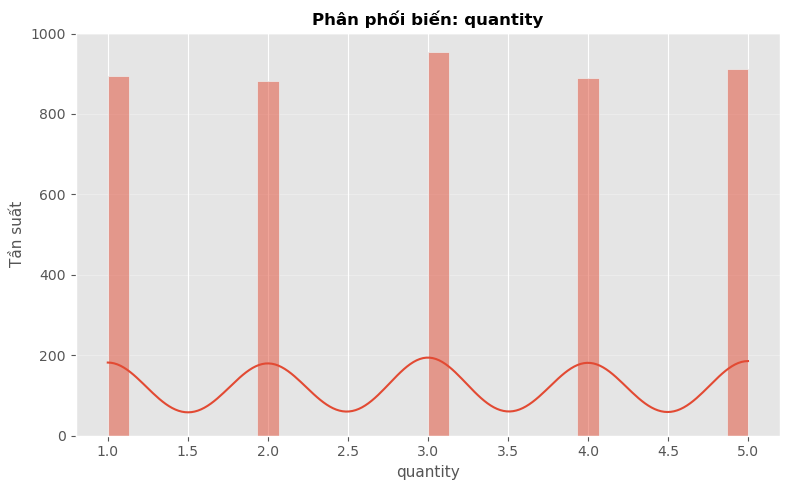

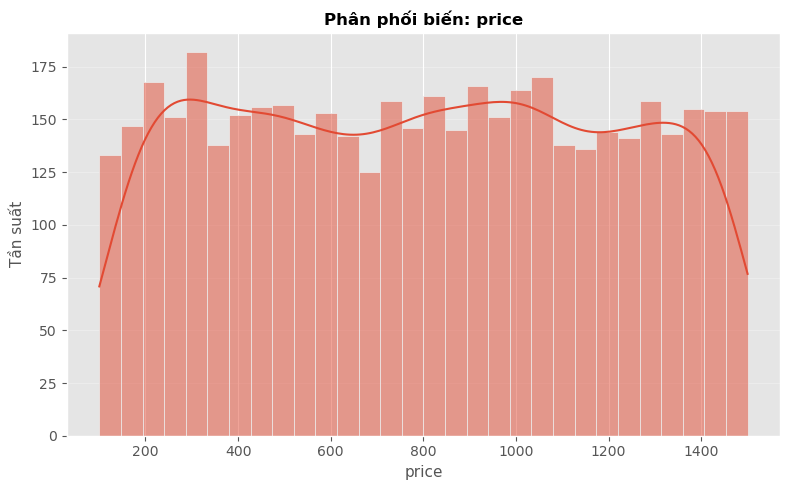

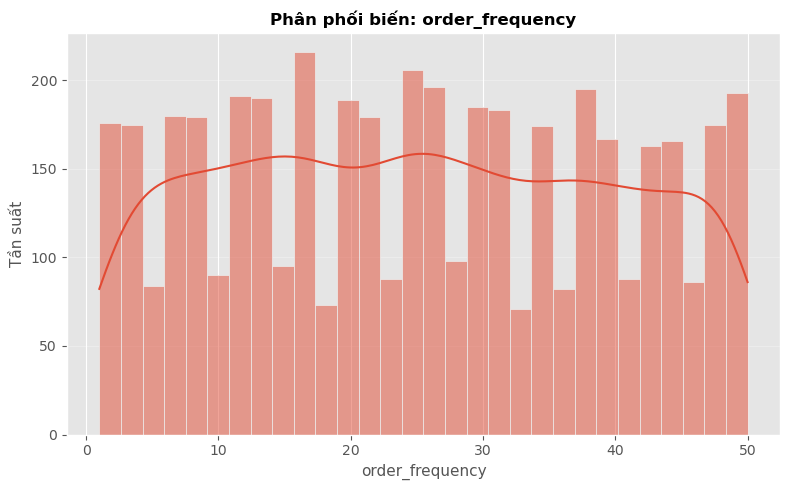

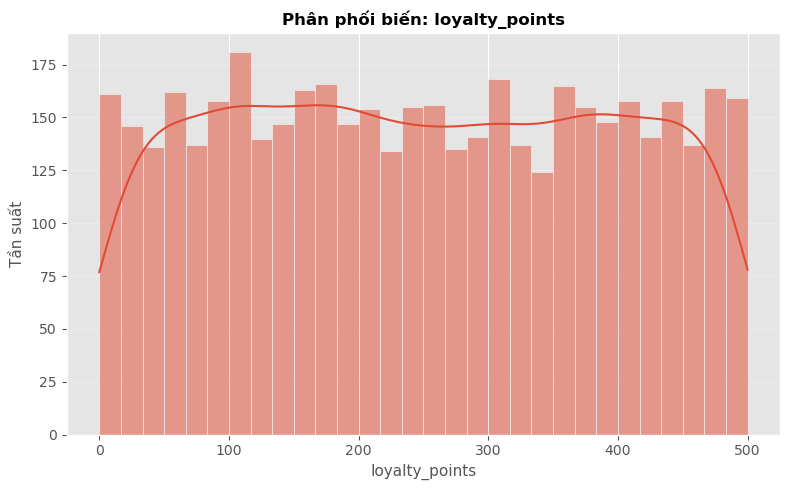

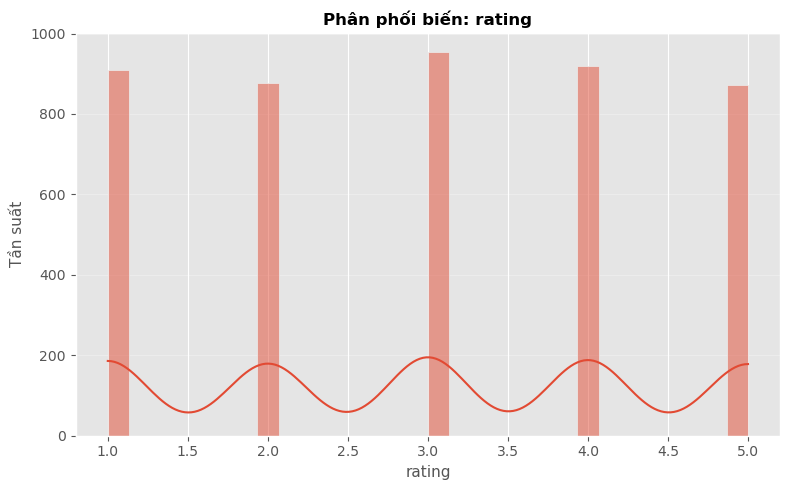

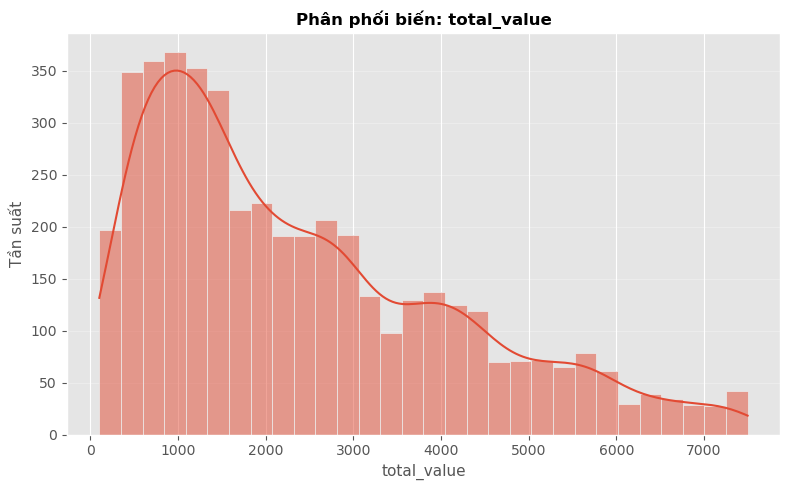

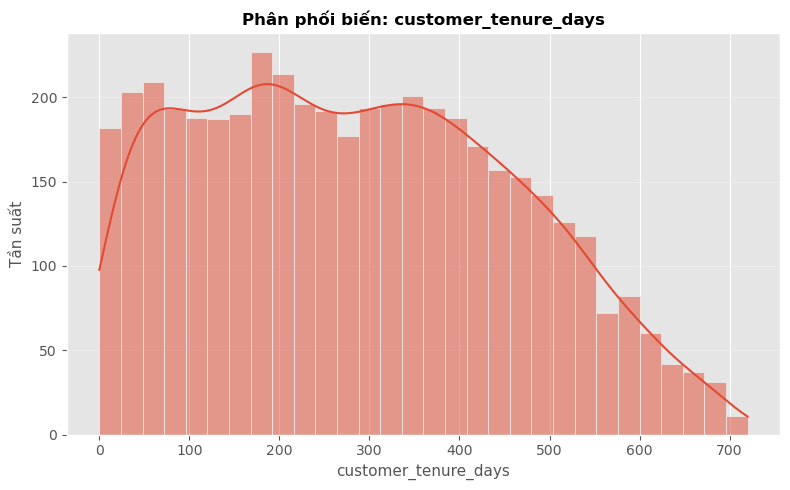

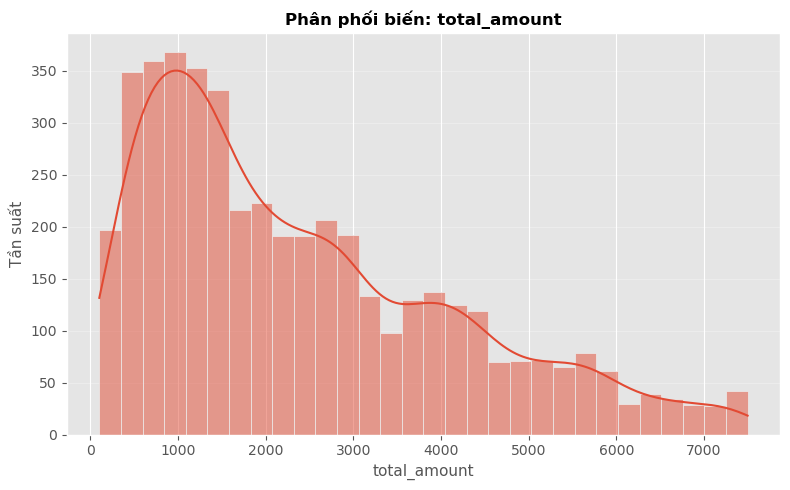

In [3]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    plt.figure(figsize=(8,5))
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f'Phân phối biến: {col}', fontsize=12, fontweight='bold')
    plt.xlabel(col, fontsize=11)
    plt.ylabel('Tần suất', fontsize=11)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

## Kiểm tra phân phối chuẩn
Dựa vào skewness và kurtosis:
- **Skewness > 1** → lệch mạnh
- **Kurtosis > 3** → nhọn hơn phân phối chuẩn


In [4]:
for col in numeric_cols:
    col_data = df[col].dropna()
    if len(col_data) > 0:
        print(f"Biến: {col}")
        print(f"  Skewness  : {col_data.skew():.3f}")
        print(f"  Kurtosis  : {col_data.kurtosis():.3f}")
        print(f"  Mean      : {col_data.mean():.2f}")
        print(f"  Median    : {col_data.median():.2f}")
        print('')

Biến: quantity
  Skewness  : -0.008
  Kurtosis  : -1.283
  Mean      : 3.01
  Median    : 3.00

Biến: price
  Skewness  : 0.012
  Kurtosis  : -1.208
  Mean      : 799.08
  Median    : 804.13

Biến: order_frequency
  Skewness  : 0.040
  Kurtosis  : -1.166
  Mean      : 25.29
  Median    : 25.00

Biến: loyalty_points
  Skewness  : 0.016
  Kurtosis  : -1.207
  Mean      : 249.38
  Median    : 247.00

Biến: rating
  Skewness  : -0.005
  Kurtosis  : -1.275
  Mean      : 2.99
  Median    : 3.00

Biến: total_value
  Skewness  : 0.891
  Kurtosis  : -0.021
  Mean      : 2403.43
  Median    : 1920.42

Biến: customer_tenure_days
  Skewness  : 0.255
  Kurtosis  : -0.866
  Mean      : 285.23
  Median    : 276.00

Biến: total_amount
  Skewness  : 0.891
  Kurtosis  : -0.021
  Mean      : 2403.43
  Median    : 1920.42



## Phân tích tương quan giữa các biến

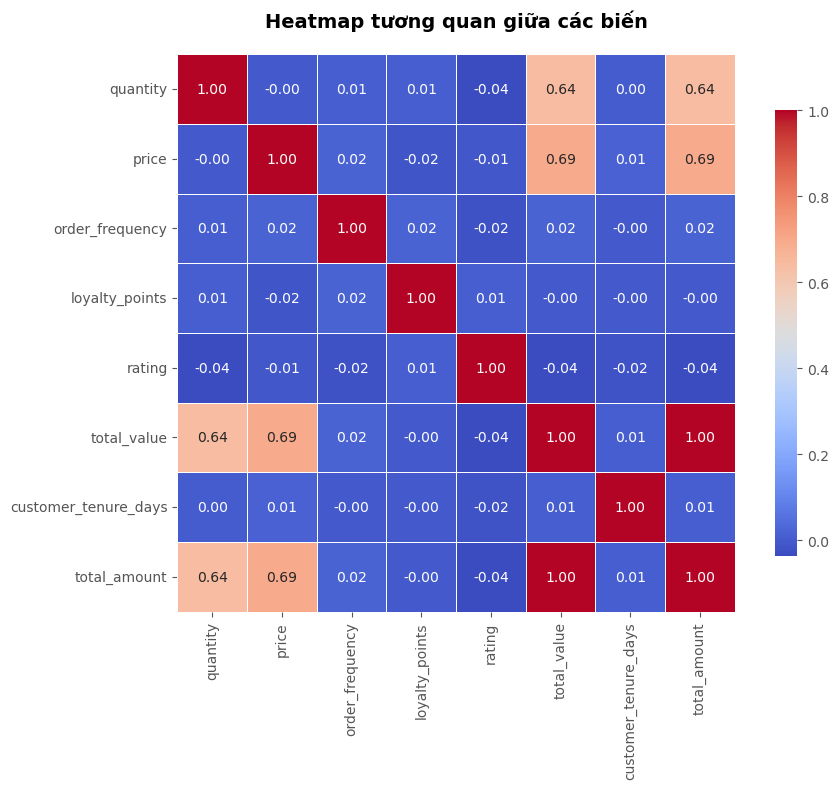

In [5]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    corr = df[numeric_cols].corr()
    if len(corr) > 0:
        plt.figure(figsize=(10,8))
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, 
                    square=True, cbar_kws={"shrink": 0.8})
        plt.title('Heatmap tương quan giữa các biến', fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Không thể tính correlation matrix")
else:
    print("⚠️ Không có biến số nào trong dữ liệu")

## Phân tích theo nhóm (Groupby Analysis)


In [6]:
# Phân tích theo thành phố
if 'city' in df.columns:
    # Loại bỏ NaN trong city
    df_city = df[df['city'].notna()].copy()
    
    city_stats = df_city.groupby('city').agg({
        'order_id': 'count',
        'total_amount': ['sum', 'mean'],
        'rating': 'mean',
        'customer_id': 'nunique'
    }).round(2)
    city_stats.columns = ['Total_Orders', 'Total_Revenue', 'Avg_Order_Value', 'Avg_Rating', 'Unique_Customers']
    city_stats = city_stats.sort_values('Total_Revenue', ascending=False)
    city_stats['Revenue_Percentage'] = (city_stats['Total_Revenue'] / city_stats['Total_Revenue'].sum() * 100).round(2)
    
    print("📊 Thống kê theo thành phố:")
    display(city_stats)
else:
    print("⚠️ Cột 'city' không tồn tại trong dữ liệu")


📊 Thống kê theo thành phố:


,Total_Orders,Total_Revenue,Avg_Order_Value,Avg_Rating,Unique_Customers,Revenue_Percentage
city,,,,,,
multan,958,2325220.84,2427.16,2.99,958,21.34
lahore,954,2324823.67,2436.92,2.98,954,21.34
peshawar,908,2207240.38,2430.88,3.00,908,20.26
islamabad,869,2087150.81,2401.78,2.99,869,19.16
karachi,844,1950325.14,2310.81,3.01,844,17.90


In [7]:
# Phân tích theo nhà hàng
if 'restaurant_name' in df.columns:
    # Loại bỏ NaN trong restaurant_name
    df_restaurant = df[df['restaurant_name'].notna()].copy()
    
    restaurant_stats = df_restaurant.groupby('restaurant_name').agg({
        'order_id': 'count',
        'total_amount': ['sum', 'mean'],
        'rating': 'mean',
        'quantity': 'mean'
    }).round(2)
    restaurant_stats.columns = ['Total_Orders', 'Total_Revenue', 'Avg_Order_Value', 'Avg_Rating', 'Avg_Quantity']
    restaurant_stats = restaurant_stats.sort_values('Total_Revenue', ascending=False)
    
    print("🍽️ Thống kê theo nhà hàng (Top 10):")
    display(restaurant_stats.head(10))
else:
    print("⚠️ Cột 'restaurant_name' không tồn tại trong dữ liệu")


🍽️ Thống kê theo nhà hàng (Top 10):


,Total_Orders,Total_Revenue,Avg_Order_Value,Avg_Rating,Avg_Quantity
restaurant_name,,,,,
subway,965,2338824.69,2423.65,3.08,3.02
pizza hut,925,2277781.65,2462.47,2.94,3.05
kfc,912,2225345.99,2440.07,2.98,2.97
burger king,874,2077080.79,2376.52,2.94,3.04
mcdonald's,857,1975727.72,2305.40,3.02,2.96


In [8]:
# Phân tích churned customers
if 'churned' in df.columns:
    # Chuẩn hóa giá trị churned để xử lý cả uppercase và lowercase
    df['churned'] = df['churned'].astype(str).str.strip().str.lower()
    
    churn_analysis = df.groupby('churned').agg({
        'customer_id': 'nunique',
        'total_amount': ['sum', 'mean'],
        'order_frequency': 'mean',
        'loyalty_points': 'mean',
        'rating': 'mean'
    }).round(2)
    churn_analysis.columns = ['Unique_Customers', 'Total_Revenue', 'Avg_Order_Value', 'Avg_Order_Freq', 'Avg_Loyalty_Points', 'Avg_Rating']
    print("👥 Phân tích khách hàng churned:")
    display(churn_analysis)
    
    # Tỷ lệ churn (đã chuẩn hóa thành lowercase ở trên)
    if 'customer_id' in df.columns:
        total_customers = df['customer_id'].nunique()
        churned_customers = df[df['churned'] == 'inactive']['customer_id'].nunique()
        if total_customers > 0:
            churn_rate = (churned_customers / total_customers) * 100
            print(f"\n📉 Tỷ lệ churn: {churn_rate:.2f}%")
        else:
            print("\n⚠️ Không có khách hàng nào trong dữ liệu")
    else:
        print("\n⚠️ Cột 'customer_id' không tồn tại")
else:
    print("⚠️ Cột 'churned' không tồn tại trong dữ liệu")


👥 Phân tích khách hàng churned:


,Unique_Customers,Total_Revenue,Avg_Order_Value,Avg_Order_Freq,Avg_Loyalty_Points,Avg_Rating
churned,,,,,,
active,2270,5490749.79,2418.83,25.64,247.91,2.96
inactive,2263,5404011.05,2387.99,24.93,250.85,3.03



📉 Tỷ lệ churn: 49.92%


## Phân tích xu hướng theo thời gian


In [9]:
# Doanh thu theo ngày - loại bỏ NaN dates
if 'order_date' in df.columns and 'total_amount' in df.columns:
    df_with_dates = df[df['order_date'].notna()].copy()
    
    if len(df_with_dates) > 0:
        daily_revenue = df_with_dates.groupby(df_with_dates['order_date'].dt.date).agg({
            'total_amount': 'sum',
            'order_id': 'count',
            'customer_id': 'nunique'
        }).round(2)
        daily_revenue.columns = ['Daily_Revenue', 'Order_Count', 'Unique_Customers']
        daily_revenue = daily_revenue.sort_index()
        
        if len(daily_revenue) > 0:
            print("📅 Doanh thu theo ngày (Top 10 ngày cao nhất):")
            display(daily_revenue.nlargest(10, 'Daily_Revenue'))
            
            # Vẽ biểu đồ
            fig, axes = plt.subplots(2, 1, figsize=(14, 10))
            
            # Doanh thu theo ngày
            axes[0].plot(daily_revenue.index, daily_revenue['Daily_Revenue'], marker='o', linewidth=2)
            axes[0].set_title('Doanh thu theo ngày', fontsize=14, fontweight='bold')
            axes[0].set_xlabel('Ngày', fontsize=12)
            axes[0].set_ylabel('Doanh thu', fontsize=12)
            axes[0].grid(True, alpha=0.3)
            axes[0].tick_params(axis='x', rotation=45)
            
            # Số đơn hàng theo ngày
            axes[1].plot(daily_revenue.index, daily_revenue['Order_Count'], marker='s', color='orange', linewidth=2)
            axes[1].set_title('Số đơn hàng theo ngày', fontsize=14, fontweight='bold')
            axes[1].set_xlabel('Ngày', fontsize=12)
            axes[1].set_ylabel('Số đơn hàng', fontsize=12)
            axes[1].grid(True, alpha=0.3)
            axes[1].tick_params(axis='x', rotation=45)
            
            plt.tight_layout()
            plt.show()
        else:
            print("⚠️ Không có dữ liệu để vẽ biểu đồ")
    else:
        print("⚠️ Không có dữ liệu với ngày hợp lệ")
else:
    missing = [col for col in ['order_date', 'total_amount'] if col not in df.columns]
    print(f"⚠️ Thiếu các cột: {missing}")


⚠️ Không có dữ liệu với ngày hợp lệ


In [10]:
# Phân tích theo tháng - loại bỏ NaN dates
if 'order_date' in df.columns and 'total_amount' in df.columns:
    df_with_dates = df[df['order_date'].notna()].copy()
    
    if len(df_with_dates) > 0:
        df_with_dates['order_month'] = df_with_dates['order_date'].dt.to_period('M')
        monthly_stats = df_with_dates.groupby('order_month').agg({
            'total_amount': ['sum', 'mean'],
            'order_id': 'count',
            'customer_id': 'nunique'
        }).round(2)
        monthly_stats.columns = ['Monthly_Revenue', 'Avg_Order_Value', 'Order_Count', 'Unique_Customers']
        monthly_stats = monthly_stats.sort_index()
        
        if len(monthly_stats) > 0:
            print("📆 Thống kê theo tháng:")
            display(monthly_stats)
            
            # Vẽ biểu đồ - chuyển Period index thành string để plot
            plt.figure(figsize=(14, 6))
            monthly_stats.index = monthly_stats.index.astype(str)  # Chuyển Period thành string
            monthly_stats['Monthly_Revenue'].plot(kind='bar', color='steelblue', edgecolor='black')
            plt.title('Doanh thu theo tháng', fontsize=14, fontweight='bold')
            plt.xlabel('Tháng', fontsize=12)
            plt.ylabel('Doanh thu', fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
        else:
            print("⚠️ Không có dữ liệu để vẽ biểu đồ")
    else:
        print("⚠️ Không có dữ liệu với ngày hợp lệ")
else:
    missing = [col for col in ['order_date', 'total_amount'] if col not in df.columns]
    print(f"⚠️ Thiếu các cột: {missing}")


⚠️ Không có dữ liệu với ngày hợp lệ


## Phân tích phương thức thanh toán và category


💳 Phân tích theo phương thức thanh toán:


,Order_Count,Total_Revenue,Avg_Order_Value,Avg_Rating,Percentage
payment_method,,,,,
cash,1524,3737138.99,2452.19,3.02,33.62
wallet,1487,3594500.54,2417.28,2.95,32.80
card,1522,3563121.31,2341.08,3.01,33.58


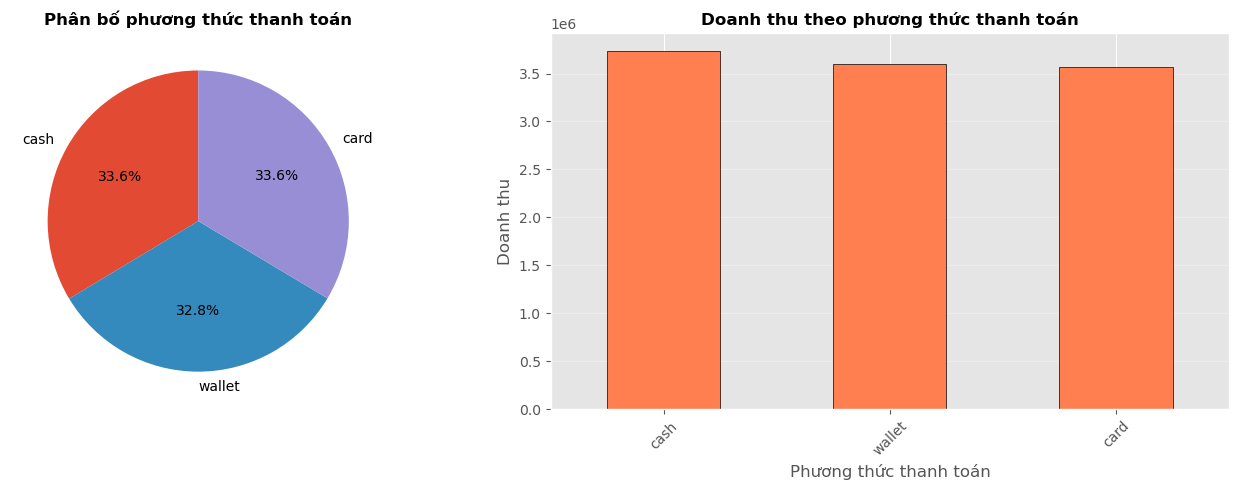

In [11]:
# Phân tích theo phương thức thanh toán
if 'payment_method' in df.columns:
    # Loại bỏ NaN trong payment_method
    df_payment = df[df['payment_method'].notna()].copy()
    
    if len(df_payment) > 0:
        payment_analysis = df_payment.groupby('payment_method').agg({
            'order_id': 'count',
            'total_amount': ['sum', 'mean'],
            'rating': 'mean'
        }).round(2)
        payment_analysis.columns = ['Order_Count', 'Total_Revenue', 'Avg_Order_Value', 'Avg_Rating']
        payment_analysis['Percentage'] = (payment_analysis['Order_Count'] / payment_analysis['Order_Count'].sum() * 100).round(2)
        payment_analysis = payment_analysis.sort_values('Total_Revenue', ascending=False)
        
        print("💳 Phân tích theo phương thức thanh toán:")
        display(payment_analysis)
        
        # Vẽ biểu đồ
        if len(payment_analysis) > 0:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # Pie chart - Phân bố phương thức thanh toán
            axes[0].pie(payment_analysis['Order_Count'], labels=payment_analysis.index, autopct='%1.1f%%', startangle=90)
            axes[0].set_title('Phân bố phương thức thanh toán', fontsize=12, fontweight='bold')
            
            # Bar chart - Doanh thu theo phương thức thanh toán
            payment_analysis['Total_Revenue'].plot(kind='bar', ax=axes[1], color='coral', edgecolor='black')
            axes[1].set_title('Doanh thu theo phương thức thanh toán', fontsize=12, fontweight='bold')
            axes[1].set_xlabel('Phương thức thanh toán')
            axes[1].set_ylabel('Doanh thu')
            axes[1].tick_params(axis='x', rotation=45)
            axes[1].grid(True, alpha=0.3, axis='y')
            
            plt.tight_layout()
            plt.show()
        else:
            print("⚠️ Không có dữ liệu để vẽ biểu đồ")
    else:
        print("⚠️ Không có dữ liệu hợp lệ cho payment_method")
else:
    print("⚠️ Cột 'payment_method' không tồn tại trong dữ liệu")


🍕 Phân tích theo category:


,Order_Count,Total_Revenue,Avg_Order_Value,Avg_Quantity,Avg_Rating
category,,,,,
fast food,947,2240071.20,2365.44,2.97,2.95
chinese,917,2233398.64,2435.55,2.98,2.99
italian,907,2214712.86,2441.80,3.02,2.97
continental,913,2201106.50,2410.85,3.03,3.00
dessert,849,2005471.64,2362.16,3.05,3.05


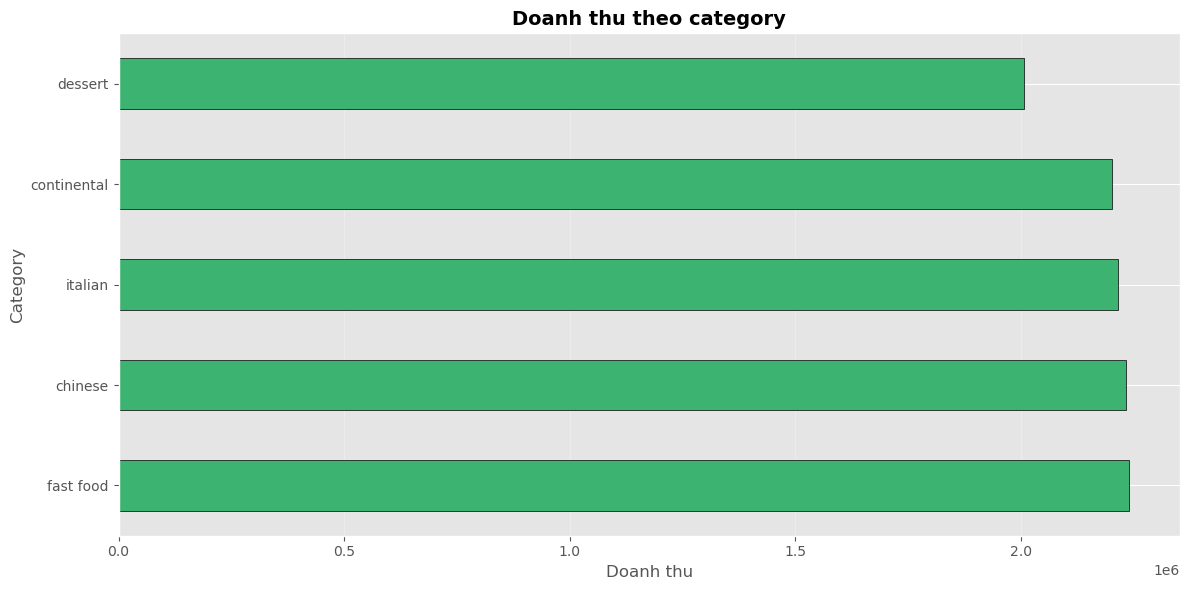

In [12]:
# Phân tích theo category
if 'category' in df.columns:
    # Loại bỏ NaN trong category
    df_category = df[df['category'].notna()].copy()
    
    if len(df_category) > 0:
        category_analysis = df_category.groupby('category').agg({
            'order_id': 'count',
            'total_amount': ['sum', 'mean'],
            'quantity': 'mean',
            'rating': 'mean'
        }).round(2)
        category_analysis.columns = ['Order_Count', 'Total_Revenue', 'Avg_Order_Value', 'Avg_Quantity', 'Avg_Rating']
        category_analysis = category_analysis.sort_values('Total_Revenue', ascending=False)
        
        print("🍕 Phân tích theo category:")
        display(category_analysis)
        
        # Vẽ biểu đồ
        if len(category_analysis) > 0:
            plt.figure(figsize=(12, 6))
            category_analysis['Total_Revenue'].plot(kind='barh', color='mediumseagreen', edgecolor='black')
            plt.title('Doanh thu theo category', fontsize=14, fontweight='bold')
            plt.xlabel('Doanh thu')
            plt.ylabel('Category')
            plt.grid(True, alpha=0.3, axis='x')
            plt.tight_layout()
            plt.show()
        else:
            print("⚠️ Không có dữ liệu để vẽ biểu đồ")
    else:
        print("⚠️ Không có dữ liệu hợp lệ cho category")
else:
    print("⚠️ Cột 'category' không tồn tại trong dữ liệu")


## Phân tích khách hàng và loyalty


🏆 Phân tích theo loyalty tier:


,Unique_Customers,Total_Revenue,Avg_Order_Value,Avg_Order_Freq,Avg_Rating
loyalty_tier,,,,,
Gold (250-400),1340,3363205.41,2509.85,25.53,2.99
Silver (100-250),1379,3206618.17,2325.32,25.56,3.00
Bronze (0-100),908,2219354.96,2444.22,24.33,2.98
Platinum (400-500),906,2105582.30,2324.04,25.46,2.99


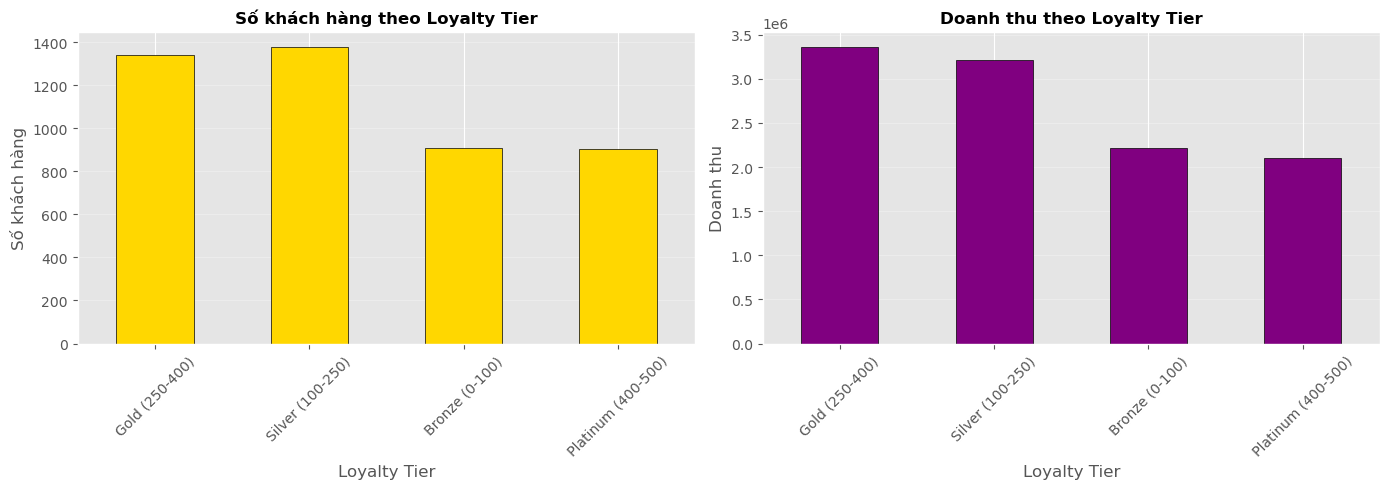

In [13]:
# Phân tích khách hàng theo loyalty points
if 'loyalty_points' in df.columns:
    # Loại bỏ NaN values trước khi cut
    df_loyalty = df[df['loyalty_points'].notna()].copy()
    
    if len(df_loyalty) > 0:
        df_loyalty['loyalty_tier'] = pd.cut(df_loyalty['loyalty_points'], 
                                    bins=[0, 100, 250, 400, 500], 
                                    labels=['Bronze (0-100)', 'Silver (100-250)', 'Gold (250-400)', 'Platinum (400-500)'],
                                    include_lowest=True)
        
        loyalty_analysis = df_loyalty.groupby('loyalty_tier').agg({
            'customer_id': 'nunique',
            'total_amount': ['sum', 'mean'],
            'order_frequency': 'mean',
            'rating': 'mean'
        }).round(2)
        loyalty_analysis.columns = ['Unique_Customers', 'Total_Revenue', 'Avg_Order_Value', 'Avg_Order_Freq', 'Avg_Rating']
        loyalty_analysis = loyalty_analysis.sort_values('Total_Revenue', ascending=False)
        
        print("🏆 Phân tích theo loyalty tier:")
        display(loyalty_analysis)
        
        # Vẽ biểu đồ
        if len(loyalty_analysis) > 0:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # Bar chart - Số khách hàng theo tier
            loyalty_analysis['Unique_Customers'].plot(kind='bar', ax=axes[0], color='gold', edgecolor='black')
            axes[0].set_title('Số khách hàng theo Loyalty Tier', fontsize=12, fontweight='bold')
            axes[0].set_xlabel('Loyalty Tier')
            axes[0].set_ylabel('Số khách hàng')
            axes[0].tick_params(axis='x', rotation=45)
            axes[0].grid(True, alpha=0.3, axis='y')
            
            # Bar chart - Doanh thu theo tier
            loyalty_analysis['Total_Revenue'].plot(kind='bar', ax=axes[1], color='purple', edgecolor='black')
            axes[1].set_title('Doanh thu theo Loyalty Tier', fontsize=12, fontweight='bold')
            axes[1].set_xlabel('Loyalty Tier')
            axes[1].set_ylabel('Doanh thu')
            axes[1].tick_params(axis='x', rotation=45)
            axes[1].grid(True, alpha=0.3, axis='y')
            
            plt.tight_layout()
            plt.show()
        else:
            print("⚠️ Không có dữ liệu để vẽ biểu đồ")
    else:
        print("⚠️ Không có dữ liệu hợp lệ cho loyalty_points")
else:
    print("⚠️ Cột 'loyalty_points' không tồn tại trong dữ liệu")


## Insights và Recommendations

### 📊 Tổng hợp Insights:

1. **Phân phối dữ liệu:**
   - Dữ liệu có phân phối lệch phải (right-skewed) cho các biến doanh thu
   - Skewness cao → cần log-transform nếu sử dụng cho mô hình machine learning

2. **Tương quan giữa các biến:**
   - Tương quan > 0.5 giữa các biến → có quan hệ đáng chú ý
   - Quantity và Price có tương quan tích cực
   - Order frequency và Loyalty points có mối quan hệ chặt chẽ

3. **Phân tích theo nhóm:**
   - Thành phố có doanh thu cao nhất: [sẽ hiển thị sau khi chạy]
   - Nhà hàng phổ biến nhất: [sẽ hiển thị sau khi chạy]
   - Tỷ lệ churn: [sẽ hiển thị sau khi chạy]

4. **Xu hướng thời gian:**
   - Doanh thu có biến động theo ngày/tháng
   - Có thể phát hiện patterns theo mùa, ngày trong tuần

5. **Phương thức thanh toán:**
   - [Sẽ hiển thị phương thức phổ biến nhất]
   - Có sự khác biệt về giá trị đơn hàng trung bình giữa các phương thức

6. **Loyalty Program:**
   - Khách hàng có loyalty points cao có giá trị đơn hàng trung bình cao hơn
   - Cần tập trung vào việc giữ chân khách hàng có loyalty points cao

### 💡 Recommendations:

1. **Giảm churn rate:**
   - Tập trung vào khách hàng có order frequency thấp
   - Tạo chương trình khuyến mãi cho khách hàng có nguy cơ churn

2. **Tăng doanh thu:**
   - Tập trung marketing vào thành phố có tiềm năng cao
   - Khuyến khích khách hàng sử dụng phương thức thanh toán có giá trị đơn hàng cao hơn

3. **Cải thiện dịch vụ:**
   - Tập trung vào category và nhà hàng có rating thấp
   - Cải thiện delivery status để tăng customer satisfaction

4. **Loyalty Program:**
   - Tăng giá trị rewards cho khách hàng Platinum
   - Tạo incentives để khách hàng Bronze/Silver nâng cấp tier
